In [182]:
def load_nli_data(path):
    """
    Load MultiNLI or SNLI data.
    """
    LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2}
    
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
            
        random.seed(1)
        random.shuffle(data)

    f.close()
    return data

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import random

df = pd.read_csv('./mturk_clean_data_3-28-21.csv')
df = df.loc[df['mask-type'] != 'original']
df['certain'] = 1
df.loc[df['flip-class'].isin(['Uncertain-Flip', 'Uncertain-Same']), 'certain'] = 0

mas_df = pd.read_csv('./Pilot_Test_Master_150-3-28-21.csv')
mas_df = mas_df.loc[mas_df['tokens-masked'] != 'original']
mas_df['orig_hypo'] = mas_df['hypothesis']

mnli = pd.DataFrame(load_nli_data('../data/MNLI/mnli_bart_test.jsonl'))

In [184]:
big_df = pd.merge(df, mas_df[['Unnamed: 0.1.1', 'token_changes', 'orig_hypo']], left_on = 'hypoID', right_on = 'Unnamed: 0.1.1')
big_df = big_df.dropna()
big_df.columns
print(big_df.shape)

(541, 17)


In [185]:
# test that the number of original hypotheses are equal to the number of premises we generate over
assert len(Counter(big_df['orig_hypo'])) == len(Counter(big_df['premID']))

In [186]:
# !curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip GloVe/glove.840B.300d.zip -d GloVe/
# !curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [187]:
import nltk

In [173]:
# Load model
from models import InferSent
import torch

model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
#model.build_vocab_k_words(K=200000)
model.build_vocab(mnli.sentence2, tokenize=True)

Found 53797(/58119) words with w2v vectors
Vocab size : 53797


In [188]:
masked_tokens = []

for i, row in big_df.iterrows():
    orig_hypo = nltk.word_tokenize(row['orig_hypo'])
    mask_hypo = nltk.word_tokenize(row['hypothesis'])
    removed = nltk.word_tokenize(row["token_changes"])
    
    masked_token = Counter(orig_hypo) - (Counter(mask_hypo) - Counter(removed))
    words = []
    for i in masked_token.items():
        words.append(i[0])
    word_out = ' '.join(words)
    masked_tokens.append(word_out)
    
big_df['masked-tokens'] = masked_tokens
big_df['filled-tokens'] = big_df['token_changes']

In [189]:
df = big_df[['orig_hypo', 'masked-tokens', 'hypothesis', 'filled-tokens', 'model-label', 'response', 'model-wrong', 'mask-type', 'flip-class', 'certain']]

(5541,)


/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


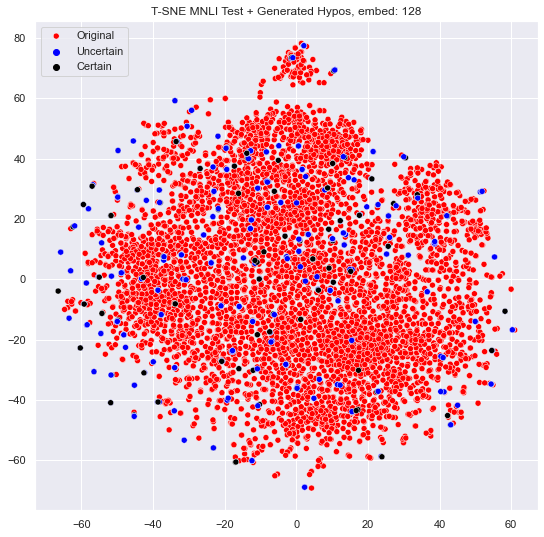

In [237]:
# extract enough test data to create map, then add in masked hypotheses. 
# include certain label to distinguish areas of low certainty
sub_sent = mnli.sentence2[0:5000]
ys = np.ones(len(sub_sent)) + 1

# add generated data 
sub_sent = sub_sent.append(df['hypothesis'])
ys = np.append(ys, df['certain'])
print(ys.shape)

#embeddings = model.encode(sub_sent, bsize=128, tokenize=True, verbose=True)
X_embedded = TSNE(n_components=2).fit_transform(embeddings)
sns.set(rc={'figure.figsize':(9,9)})
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = ys, palette=['blue', 'black', 'red'])
plt.legend(loc='upper left', labels=['Original', 'Uncertain', 'Certain'])
plt.title("T-SNE MNLI Test + Generated Hypos, embed: 128")
plt.savefig('../graphs/T-SNE_generated_hypos.png', dpi=200)

In [198]:
nodup = df.copy()
nodup = nodup.drop_duplicates(subset=['orig_hypo'])

Nb words kept : 2230/2236 (99.7%)
Speed : 29.6 sentences/s (cpu mode, bsize=128)


/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

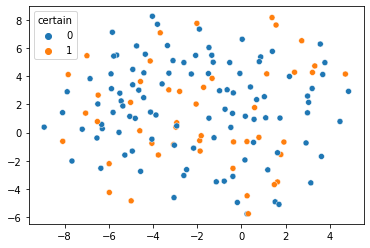

In [200]:
embeddings = model.encode(nodup['orig_hypo'], bsize=128, tokenize=True, verbose=True)
X_embedded = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = nodup['certain'])

Nb words kept : 8190/8224 (99.6%)


/Users/johnnyma/Documents/GitHub/MP-Edit/notebooks/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 30.1 sentences/s (cpu mode, bsize=128)


<ipython-input-194-9e976b4be87a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hypo_embed'] = [i for i in embeddings]
/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

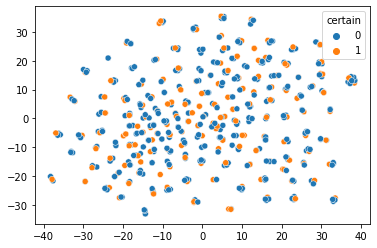

In [194]:
embeddings = model.encode(df['hypothesis'], bsize=128, tokenize=True, verbose=True)
df['hypo_embed'] = [i for i in embeddings]
X_embedded = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = df['certain'])

Nb words kept : 2507/2520 (99.5%)


/Users/johnnyma/Documents/GitHub/MP-Edit/notebooks/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 92.8 sentences/s (cpu mode, bsize=128)


<ipython-input-240-d03b3236d452>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fill_embed'] = [i for i in embeddings]
/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


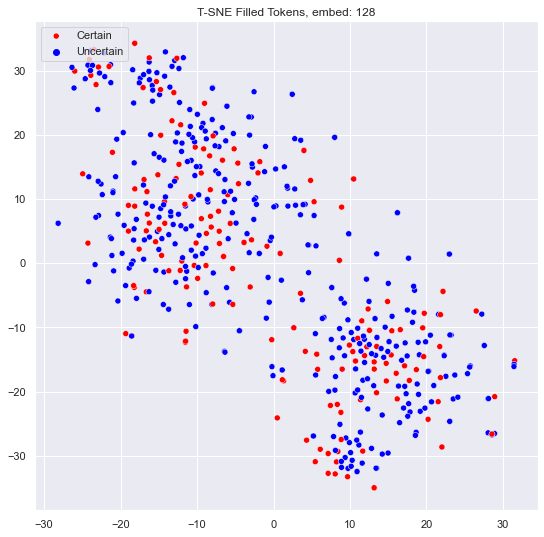

In [240]:
embeddings = model.encode(df['filled-tokens'], bsize=128, tokenize=True, verbose=True)
df['fill_embed'] = [i for i in embeddings]
X_embedded = TSNE(n_components=2).fit_transform(embeddings)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = df['certain'], palette=['blue', 'red'])
plt.legend(loc='upper left', labels=['Certain', 'Uncertain'])
plt.title("T-SNE Filled Tokens, embed: 128")
plt.savefig('../graphs/T-SNE_filled_tokens.png', dpi=200)

Nb words kept : 2462/2463 (100.0%)


/Users/johnnyma/Documents/GitHub/MP-Edit/notebooks/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 102.3 sentences/s (cpu mode, bsize=128)


/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


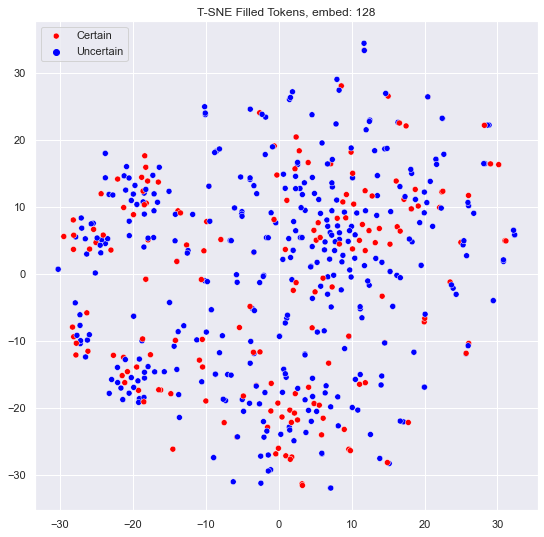

In [239]:
embeddings = model.encode(df['masked-tokens'], bsize=128, tokenize=True, verbose=True)
X_embedded = TSNE(n_components=2).fit_transform(embeddings)
#sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = df['certain'])

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = df['certain'], palette=['blue', 'red'])
plt.legend(loc='upper left', labels=['Certain', 'Uncertain'])
plt.title("T-SNE Filled Tokens, embed: 128")
plt.savefig('../graphs/T-SNE_masked_tokens.png', dpi=200)